# Use TLS with Let's Encrypt

Create an ingress controller with a static public IP address in Azure Kubernetes Service.

## Prerequisites
* Have an existing AKS cluster, or see the AKS quickstart using the [Azure CLI](https://docs.microsoft.com/en-us/azure/aks/kubernetes-walkthrough) or using the Azure portal.
* Have Helm 3 to install the NGINX ingress controller on a supported version of Kubernetes. Make sure that you are using the latest release of [Helm](https://helm.sh/) and have access to the ingress-nginx and jetstack Helm repositories. 
* Run Azure [CLI](https://docs.microsoft.com/en-us/cli/azure/install-azure-cli) version 2.0.64 or later.


## Create an Ingress Controller
This approach allows you to use existing DNS records and network configurations in a consistent manner throughout the lifecycle of your applications.  If you need to create a static public IP address, first get the resource group name of the AKS cluster with the az aks show command:


In [2]:
az aks show --resource-group myResourceGroup --name myAKSCluster --query nodeResourceGroup -o tsv

MC_myResourceGroup_myAKSCluster_eastus


Next, create a public IP address with the static allocation method using the az network public-ip create command. The following example creates a public IP address named myAKSPublicIP in the AKS cluster resource group obtained in the previous step:

In [3]:
az network public-ip create --resource-group MC_myResourceGroup_myAKSCluster_eastus --name myAKSPublicIP --sku Standard --allocation-method static --query publicIp.ipAddress -o tsv

[Coming breaking change] In the coming release, the default behavior will be changed as follows when sku is Standard and zone is not provided: For zonal regions, you will get a zone-redundant IP indicated by zones:["1","2","3"]; For non-zonal regions, you will get a non zone-redundant IP indicated by zones:null.
23.96.80.214


Now deploy the nginx-ingress chart with Helm. You must pass two additional parameters to the Helm release so the ingress controller is made aware both of the static IP address of the load balancer to be allocated to the ingress controller service, and of the DNS name label being applied to the public IP address resource. For the HTTPS certificates to work correctly, a DNS name label is used to configure an FQDN for the ingress controller IP address.

* Add the *--set controller.service.loadBalancerIP* parameter. Specify your own public IP address that was created in the previous step.
* Add the *--set controller.service.annotations."service\.beta\.kubernetes\.io/azure-dns-label-name"* parameter. Specify a DNS name label to be applied to the public IP address that was created in the previous step.
* The ingress controller also needs to be scheduled on a Linux node. Windows Server nodes shouldn't run the ingress controller. A node selector is specified using the --set nodeSelector parameter to tell the Kubernetes scheduler to run the NGINX ingress controller on a Linux-based node.

replace STATIC_IP and DNS_LABEL with your own IP address and unique name when running the command.

In [4]:
# Add the ingress-nginx repository
helm repo add ingress-nginx https://kubernetes.github.io/ingress-nginx

# Use Helm to deploy an NGINX ingress controller
helm install nginx-ingress ingress-nginx/ingress-nginx \
    --set controller.replicaCount=2 \
    --set controller.nodeSelector."beta\.kubernetes\.io/os"=linux \
    --set defaultBackend.nodeSelector."beta\.kubernetes\.io/os"=linux \
    --set controller.admissionWebhooks.patch.nodeSelector."beta\.kubernetes\.io/os"=linux \
    --set controller.service.loadBalancerIP="23.96.80.214" \
    --set controller.service.annotations."service\.beta\.kubernetes\.io/azure-dns-label-name"="ingress-dns"

"ingress-nginx" already exists with the same configuration, skipping
NAME: nginx-ingress
LAST DEPLOYED: Tue Jul  6 23:38:13 2021
NAMESPACE: default
STATUS: deployed
REVISION: 1
TEST SUITE: None
NOTES:
The ingress-nginx controller has been installed.
It may take a few minutes for the LoadBalancer IP to be available.
You can watch the status by running 'kubectl --namespace default get services -o wide -w nginx-ingress-ingress-nginx-controller'

An example Ingress that makes use of the controller:

  apiVersion: networking.k8s.io/v1beta1
  kind: Ingress
  metadata:
    annotations:
      kubernetes.io/ingress.class: nginx
    name: example
    namespace: foo
  spec:
    rules:
      - host: www.example.com
        http:
          paths:
            - backend:
                serviceName: exampleService
                servicePort: 80
              path: /
    # This section is only required if TLS is to be enabled for the Ingress
    tls:
        - hosts:
            - www.example.com
   

When the Kubernetes load balancer service is created for the NGINX ingress controller, your static IP address is assigned.  The external IP may take minutes to create:

In [ ]:
kubectl get services -o wide -w nginx-ingress-ingress-nginx-controller

NAME                                     TYPE           CLUSTER-IP   EXTERNAL-IP   PORT(S)                      AGE     SELECTOR
nginx-ingress-ingress-nginx-controller   LoadBalancer   10.0.52.93   <pending>     80:31580/TCP,443:30554/TCP   2m22s   app.kubernetes.io/component=controller,app.kubernetes.io/instance=nginx-ingress,app.kubernetes.io/name=ingress-nginx


You can verify that the DNS name label has been applied by querying the FQDN on the public IP address:


In [ ]:
az network public-ip list --resource-group MC_myResourceGroup_myAKSCluster_eastus --query "[?name=='myAKSPublicIP'].[dnsSettings.fqdn]" -o tsv

The ingress controller is now accessible through the IP address or the FQDN.

## Install cert-manager
Using cert-manager provides automatic Lets Encrypt certificate generation and management functionality.  To install the cert-manager controller in an Kubernetes RBAC-enabled cluster, use the following helm install command:



In [ ]:
# Add the Jetstack Helm repository
helm repo add jetstack https://charts.jetstack.io

# Update your local Helm chart repository cache
helm repo update

# Install the cert-manager Helm chart
helm install \
  cert-manager \
  --version v1.3.1 \
  --set installCRDs=true \
  --set nodeSelector."beta\.kubernetes\.io/os"=linux \
  jetstack/cert-manager

In [ ]:
# Output of cert-manager installation
NAME: cert-manager
LAST DEPLOYED: Fri Jul  2 08:28:59 2021
NAMESPACE: default
STATUS: deployed
REVISION: 1
TEST SUITE: None
NOTES:
cert-manager has been deployed successfully!

In order to begin issuing certificates, you will need to set up a ClusterIssuer
or Issuer resource (for example, by creating a 'letsencrypt-staging' issuer).

More information on the different types of issuers and how to configure them
can be found in our documentation:

https://cert-manager.io/docs/configuration/

For information on how to configure cert-manager to automatically provision
Certificates for Ingress resources, take a look at the `ingress-shim`
documentation:


## Create a CA cluster Issuer
Before certificates can be issued, cert-manager requires an Issuer or ClusterIssuer resource. These Kubernetes resources are identical in functionality, however Issuer works in a single namespace, and ClusterIssuer works across all namespaces. For more information, see the cert-manager issuer documentation.
* Create a cluster issuer, such as **cluster-issuer.yaml**, using the following example manifest. Update the email address with a valid address from your organization:

In [ ]:
nano cluster-issuer.yaml

In [ ]:
apiVersion: cert-manager.io/v1alpha2
kind: ClusterIssuer
metadata:
  name: letsencrypt-staging
spec:
  acme:
    server: https://acme-staging-v02.api.letsencrypt.org/directory
    email: email@example.com
    privateKeySecretRef:
      name: letsencrypt-staging
    solvers:
    - http01:
        ingress:
          class: nginx
          PodTemplate:
            spec:
              NodeSelector:
                "kubernetes.io/os": linux

To create the issuer, use the kubectl apply command.

In [ ]:
$ kubectl apply -f cluster-issuer.yaml
clusterissuer.cert-manager.io/letsencrypt-staging created

## Run applications
An ingress controller and a certificate management solution have been configured. Now deploy the application eclwatch by opening a file, named **eclwatch.yaml**

In [ ]:
nano eclwatch.yaml

In [ ]:
apiVersion: networking.k8s.io/v1
kind: Ingress
metadata:
  name: eclwatch-ingress
  annotations:
    kubernetes.io/ingress.class: nginx
spec:
  rules:
  -  http:
      paths:
      - path: /
        pathType: Prefix
        backend:
         service:
           name: eclwatch
           port:
             number: 8010
---
apiVersion: v1
kind: Service
metadata:
  name: eclwatch
spec:
  type: ClusterIP
  ports:
  - port: 8010

In [ ]:
$ kubectl apply -f eclwatch.yaml
service/eclwatch created

## Create an Ingress route
The application is now running on your Kubernetes cluster, however it is configured with a service of type ClusterIP, so they aren't accessible to the internet.  To make them publicly available, create a Kubernetes ingress resource. The ingress resource configures the rules that route traffic to the application.
* Create a file named ingress-route.yaml, and copy in the following:

In [ ]:
apiVersion: networking.k8s.io/v1
kind: Ingress
metadata:
  name: eclwatch-ingress
  annotations:
    kubernetes.io/ingress.class: nginx
    cert-manager.io/cluster-issuer: letsencrypt-staging
    nginx.ingress.kubernetes.io/rewrite-target: /$1
    nginx.ingress.kubernetes.io/use-regex: "true"
spec:
  tls:
  - hosts:
    - ingress-dns.eastus.cloudapp.azure.com
    secretName: tls-secret
  rules:
  - host: ingress-dns.eastus.cloudapp.azure.com
    http:
      paths:
      - path: /
        pathType: Prefix
        backend:
          service:
            name: eclwatch
            port:
              number: 8010

* Create the ingress resource 

In [ ]:
$ kubectl apply -f ingress-route.yaml
ingress.networking.k8s.io/eclwatch-ingress configured

## Create a certificate object
Cert-manager has likely automatically created a certificate object for you using ingress-shim, which is automatically deployed with cert-manager since v0.2.2. To verify that the certificate was created successfully, use the **kubectl describe certificate tls-secret**  command.

If the certificate was issued, you will see output similar to the following:

In [ ]:
$ kubectl describe certificate tls-secret
Type    Reason          Age   From          Message
----    ------          ----  ----          -------
  Normal  CreateOrder     11m   cert-manager  Created new ACME order, attempting validation...
  Normal  DomainVerified  10m   cert-manager  Domain "DNS" verified with "http-01" validation
  Normal  IssueCert       10m   cert-manager  Issuing certificate...
  Normal  CertObtained    10m   cert-manager  Obtained certificate from ACME server
  Normal  CertIssued      10m   cert-manager  Certificate issued successfully

If you need to create an additional certificate resource, you can do so with the following example manifest. Update the dnsNames and domains to the DNS name you created in a previous step. If you use an internal-only ingress controller, specify the internal DNS name for your service.

In [ ]:
apiVersion: cert-manager.io/v1alpha2
kind: Certificate
metadata:
  name: tls-secret
  namespace: ingress-basic
spec:
  secretName: tls-secret
  dnsNames:
  - # Your DNS
  acme:
    config:
    - http01:
        ingressClass: nginx
      domains:
      - # DNS
  issuerRef:
    name: letsencrypt-staging
    kind: ClusterIssuer

To create the certificate resource, use the kubectl apply command:

In [ ]:
$ kubectl apply -f certificates.yaml
certificate.cert-manager.io/tls-secret created

## Test the Ingress Configuration
Open a web browser to the FQDN of your Kubernetes ingress controller. https://demo-aks-ingress.eastus.cloudapp.azure.com.

As these examples use letsencrypt-staging, the issued TLS/SSL certificate is not trusted by the browser. Accept the warning prompt to continue to your application. The certificate information shows this Fake LE Intermediate X1 certificate is issued by Let's Encrypt. This fake certificate indicates cert-manager processed the request correctly and received a certificate from the provider:

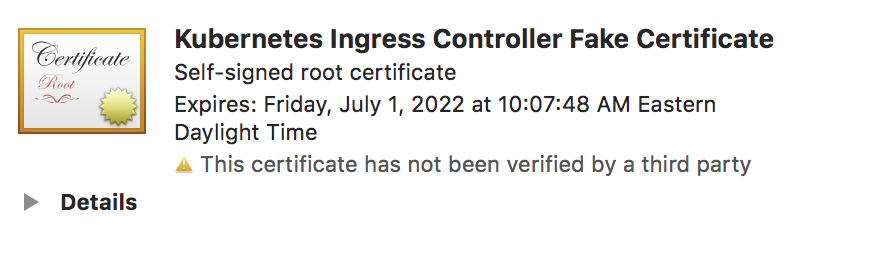

When you change Let's Encrypt to use prod rather than staging, a trusted certificate issued by Let's Encrypt is used, as shown in the following example:


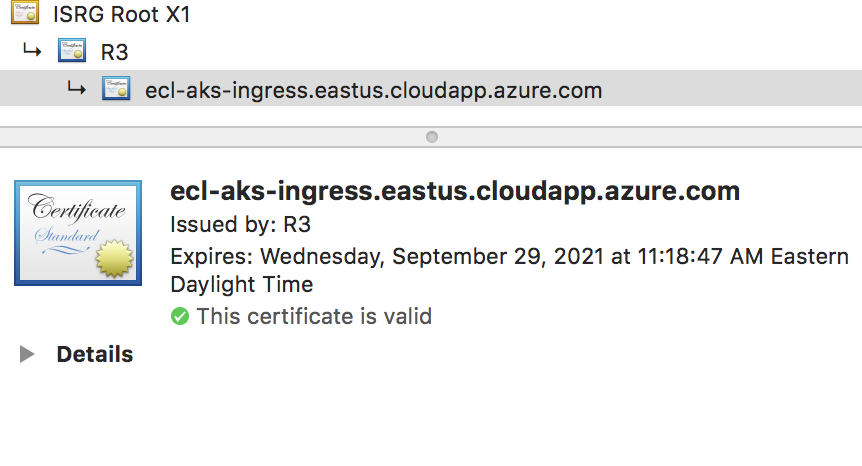

# Cleanup resources
Delete resources individually

First, remove the certificate resources:

In [ ]:
kubectl delete -f certificates.yaml
kubectl delete -f cluster-issuer.yaml

Now list the Helm releases with the helm list command. Look for charts named nginx-ingress and cert-manager as shown in the following example output:

In [ ]:
helm list --all-namespaces

NAME                    NAMESPACE       REVISION        UPDATED                        STATUS          CHART                   APP VERSION
nginx-ingress           ingress-basic   1               2020-01-11 14:51:03.454165006  deployed        nginx-ingress-1.28.2    0.26.2
cert-manager            ingress-basic   1               2020-01-06 21:19:03.866212286  deployed        cert-manager-v0.13.0    v0.13.0

Uninstall the releases with the helm uninstall command. The following example uninstalls the NGINX ingress deployment and certificate manager deployments.

In [ ]:
$ helm uninstall nginx-ingress cert-manager -n ingress-basic

release "nginx-ingress" deleted
release "cert-manager" deleted

Next, remove the sample applications:

In [ ]:
kubectl delete -f eclwatch.yaml
kubectl delete -f ingress-route.yaml

Finally, remove the static public IP address created for the ingress controller. Provide your MC_ cluster resource group name obtained in the first step of this article, such as MC_myResourceGroup_myAKSCluster_eastus:

In [ ]:
az network public-ip delete --resource-group MC_myResourceGroup_myAKSCluster_eastus --name myAKSPublicIP